In [4]:
from src.aco_mapf.AcoAgent import AcoAgent, Colony
from src.aco_mapf.GraphWorld import GraphWorld, TestProblem
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from ExperimentRunner.ExperimentRunner import Experiment, Parameter
import ipyparallel as ipp
from IPython.display import display


## Simple Testing of the ACO algorithm

In [49]:
colony = Colony()
agents = [AcoAgent(seed=i, colony=colony) for i in range(2)]
test1 = TestProblem(seed=42).hard_2(agents=agents)

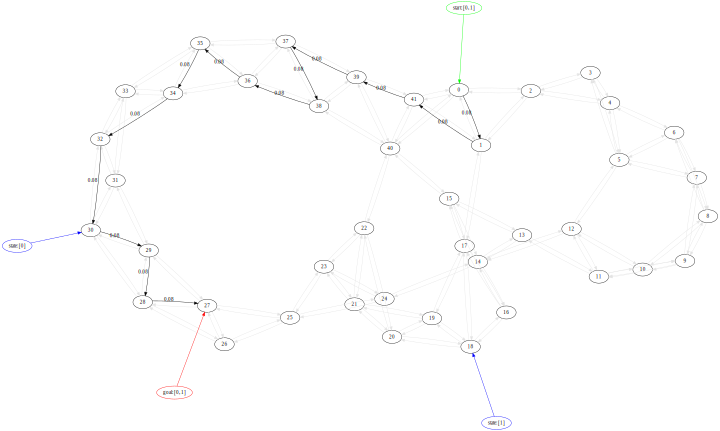

In [73]:
dot = test1.dot_graph(pheromones=colony.pheromones)
dot.attr(size="10,10")
display(dot)
test1.step()

In [67]:
for _ in range(10):
    test1.step()

In [ ]:

@ipp.require("pandas as pd", "numpy as np", GraphWorld, TestProblem, AcoAgent, Colony)
def run_testprolem_aco(seed=0, steps=10):
    c = Colony()
    agents = [AcoAgent(seed=seed+offset, colony=c) for offset in range(1)]
    problem = TestProblem(seed=seed).hard_2(agents=agents)
    for _ in range(steps):
        problem.step()
    df = problem.get_data() 
    return df


In [ ]:
parameters = [Parameter(name="steps", default=100, space=[100 * i for i in range(1,15)])]
experiment = Experiment(seed=1, function=run_testprolem_aco, parameters=parameters, runs=9)

In [ ]:
experiment.generate_tasks()

In [ ]:
df = experiment.run_map()

In [ ]:
experiment.rc.history

In [ ]:
sns.lmplot(data=experiment.results, x="steps", y="max_best_distance", order=1)
plt.show()

In [ ]:
sns.lmplot()